In [1]:
# Imports
import os
import pandas as pd
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt

In [2]:
y, sr = librosa.load('../Data/genres/audiofiles/blues/blues.00000.wav')

In [3]:
sr

22050

In [4]:
y.shape

(661794,)

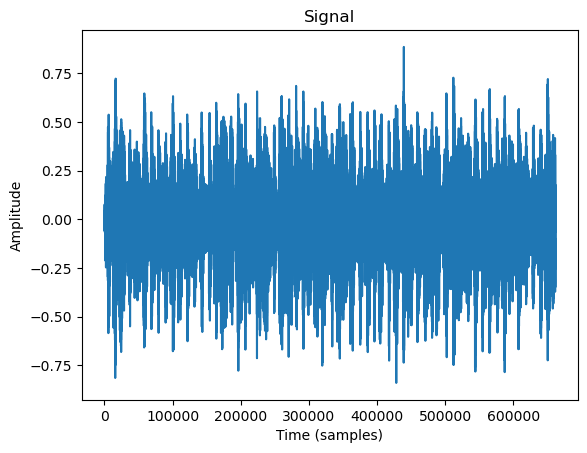

In [5]:
plt.plot(y);
plt.title('Signal');
plt.xlabel('Time (samples)');
plt.ylabel('Amplitude');

In [6]:
n_fft = 2048
ft = np.abs(librosa.stft(y[:n_fft], hop_length = n_fft+1))

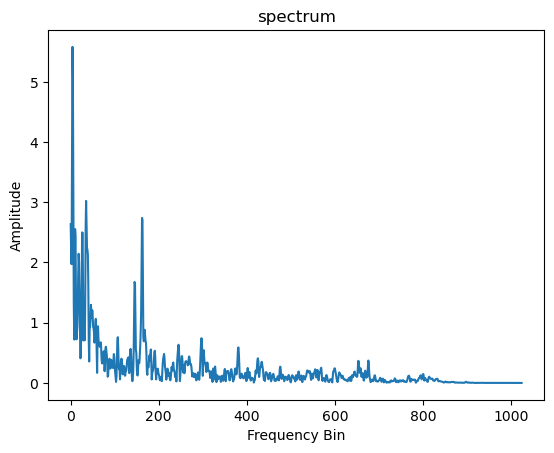

In [7]:
plt.plot(ft);
plt.title('spectrum');
plt.xlabel('Frequency Bin');
plt.ylabel('Amplitude');

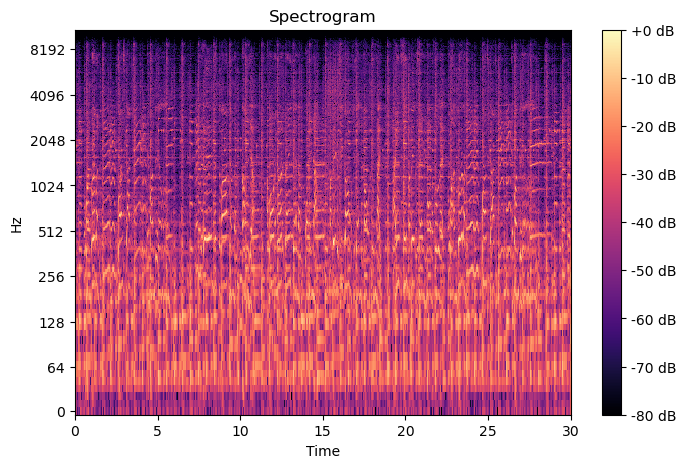

In [8]:
# Computing the spectrogram
spec = np.abs(librosa.stft(y, hop_length=512))
spec = librosa.amplitude_to_db(spec, ref=np.max) # converting to decibals

# Plotting the spectrogram
plt.figure(figsize=(8,5));
librosa.display.specshow(spec, sr=sr, x_axis='time', y_axis='log');
plt.colorbar(format='%+2.0f dB');
plt.title('Spectrogram');

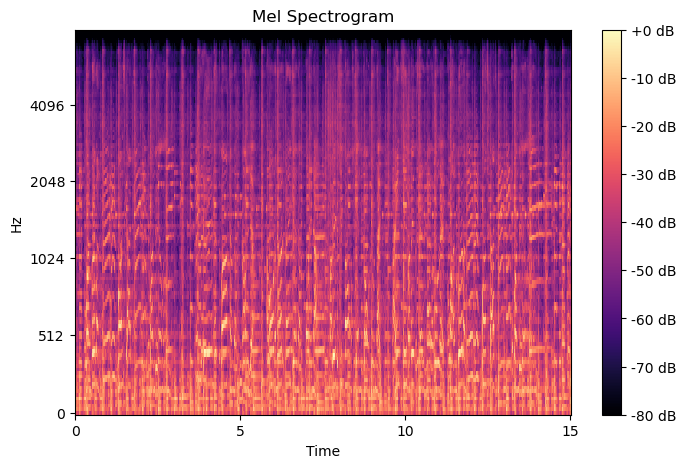

In [9]:
spect = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=2048, hop_length=1024)
spect = librosa.power_to_db(spect, ref=np.max) # Converting to decibals

# Plotting the mel spectrogram
plt.figure(figsize=(8,5))
librosa.display.specshow(spect, y_axis='mel', fmax=8000, x_axis='time');
plt.title('Mel Spectrogram');
plt.colorbar(format='%+2.0f dB');

In [10]:
# Extracting mfccs from the audio signal
mfcc = librosa.feature.mfcc(y=y, sr=sr, hop_length=512, n_mfcc=13)

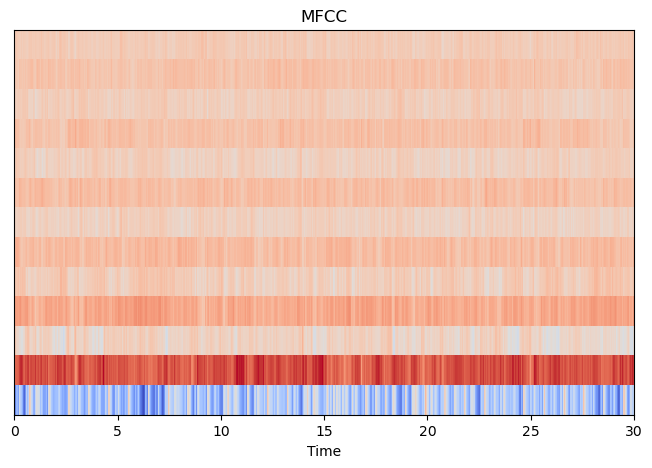

In [11]:
# Displaying the mfccs
plt.figure(figsize=(8,5));
librosa.display.specshow(mfcc, x_axis='time');
plt.title('MFCC');

In [12]:
# Scaling the mfccs
mfccscaled = np.mean(mfcc.T, axis=0)
mfccscaled

array([-113.59882  ,  121.57067  ,  -19.162262 ,   42.36394  ,
         -6.362266 ,   18.621931 ,  -13.699734 ,   15.339802 ,
        -12.274304 ,   10.970945 ,   -8.326061 ,    8.802088 ,
         -3.6699412], dtype=float32)

In [13]:
# Creating an empty list to store sizes in
sizes = []

# Looping through each audio file
path = os.path.join(os.path.pardir, 'Data', 'genres', 'audiofiles')
for entry in os.scandir(path):
    if entry.is_dir():  
        for file in os.scandir(entry):
            # Loading in the audio file
            y, sr = librosa.core.load(file)

            # Computing the mel spectrograms
            spect = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=2048, hop_length=1024)
            spect = librosa.power_to_db(spect, ref=np.max)
            
            # Adding the size to the list
            sizes.append(spect.shape)

    elif entry.is_file():  
        print(f'- {entry.name}')
    else:  
        print(f'{entry.name}?')
    
# Checking if all sizes are the same
print(f'The sizes of all the mel spectrograms in our data set are equal: {len(set(sizes)) == 1}')

# Checking the max size
print(f'The maximum size is: {max(sizes)}')

The sizes of all the mel spectrograms in our data set are equal: False
The maximum size is: (128, 660)


In [14]:
def extract_mel_spectrogram(directory):
    '''
    This function takes in a directory of audio files in .wav format, computes the
    mel spectrogram for each audio file, reshapes them so that they are all the 
    same size, and stores them in a numpy array. 
    
    It also creates a list of genre labels and maps them to numeric values.
    
    Parameters:
    directory (int): a directory of audio files in .wav format
    
    Returns:
    X (array): array of mel spectrogram data from all audio files in the given
    directory
    y (array): array of the corresponding genre labels in numeric form
    '''
    
    # Creating empty lists for mel spectrograms and labels
    labels = []
    mel_specs = []
    
    # Looping through each file in the directory
    for entry in os.scandir(directory):
        if entry.is_dir():  
            for file in os.scandir(entry):
                # Loading in the audio file
                y, sr = librosa.core.load(file)
                
                # Extracting the label and adding it to the list
                label = str(file).split('.')[0][11:]
                labels.append(label)
                
                # Computing the mel spectrograms
                spect = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=2048, hop_length=1024)
                spect = librosa.power_to_db(spect, ref=np.max)
                
                # Adjusting the size to be 128 x 660
                if spect.shape[1] != 660:
                    spect.resize(128 , 660, refcheck=False)
                    
                # Adding the mel spectrogram to the list
                mel_specs.append(spect)
        elif entry.is_file():  
            print(f'- {entry.name}')
        else:  
            print(f'{entry.name}?')
        
    # Converting the list or arrays to an array
    X = np.array(mel_specs)
    
    # Converting labels to numeric values
    labels = pd.Series(labels)
    label_dict = {
        'jazz': 1,
        'reggae': 2,
        'rock': 3,
        'blues': 4,
        'hiphop': 5,
        'country': 6,
        'metal': 7,
        'classical': 8,
        'disco': 9,
        'pop': 10
    }
    y = labels.map(label_dict)
    
    # Returning the mel spectrograms and labels
    return X, y

In [15]:
def make_mel_spectrogram_df(directory):
    '''
    This function takes in a directory of audio files in .wav format, computes the
    mel spectrogram for each audio file, reshapes them so that they are all the 
    same size, flattens them, and stores them in a dataframe.
    
    Genre labels are also computed and added to the dataframe.
    
    Parameters:
    directory (int): a directory of audio files in .wav format
    
    Returns:
    df (DataFrame): a dataframe of flattened mel spectrograms and their 
    corresponding genre labels
    '''
    
    # Creating empty lists for mel spectrograms and labels
    labels = []
    mel_specs = []
    
    # Looping through each file in the directory
    for entry in os.scandir(directory):
        if entry.is_dir():  
            for file in os.scandir(entry):
                # Loading in the audio file
                y, sr = librosa.core.load(file)
                
                # Extracting the label and adding it to the list
                label = str(file).split('.')[0][11:]
                labels.append(label)
                
                # Computing the mel spectrograms
                spect = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=2048, hop_length=1024)
                spect = librosa.power_to_db(spect, ref=np.max)
                
                # Adjusting the size to be 128*660
                if spect.shape[1] != 660:
                    spect.resize(128, 660, refcheck=False)
                
                # Flattening to fit into dataframe and adding to the list
                spect = spect.flatten()
                mel_specs.append(spect)
        elif entry.is_file():  
            print(f'- {entry.name}')
        else:  
            print(f'{entry.name}?')
        
    # Converting the lists to arrays so we can stack them
    mel_specs = np.array(mel_specs)
    labels = np.array(labels).reshape(1000,1)
    
    # Create dataframe
    df = pd.DataFrame(mel_specs)
    df['label'] = labels
    
    # Returning the mel spectrograms and labels
    return df

In [16]:
# Using the above function to create a dataframe with all of the flattened mel spectrograms and genre labels
df = make_mel_spectrogram_df(path)

In [17]:
df

,0,1,2,3,4,5,6,7,8,9,...,84471,84472,84473,84474,84475,84476,84477,84478,84479,label
0,-33.144764,-34.706394,-30.291473,-31.983377,-34.712521,-18.918961,-20.785999,-28.106270,-35.856041,-35.904282,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,blues
1,-33.348507,-17.828934,-16.082321,-21.429171,-23.704781,-29.580908,-28.251745,-31.718090,-36.745407,-38.221283,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,blues
2,-33.078190,-38.951023,-38.105515,-36.680084,-33.892109,-34.302193,-28.007008,-34.434010,-39.126560,-44.014328,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,blues
3,-28.873878,-38.427704,-44.643795,-43.343048,-49.787849,-49.419289,-45.321747,-45.884949,-48.977386,-47.326611,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,blues
4,-57.916531,-53.033882,-52.625343,-54.882698,-45.236115,-44.029240,-50.053173,-53.218079,-59.152702,-54.893375,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,blues
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,-27.562012,-47.691639,-46.345024,-49.496147,-39.209770,-42.822441,-52.434319,-48.826759,-55.493858,-49.966072,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,rock
996,-25.390690,-39.733505,-39.478149,-40.505798,-41.403725,-37.357140,-40.387814,-37.235870,-41.253105,-35.735016,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,rock
997,-36.710445,-35.052551,-32.945099,-37.010288,-53.510582,-46.685360,-28.989197,-19.120363,-28.009514,-33.686371,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,rock
998,-30.008583,-18.121990,-31.136040,-36.531181,-29.365623,-28.642797,-35.535664,-46.901920,-41.276875,-36.719627,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,rock


In [18]:

df.to_csv('../Data/genre_mel_specs.csv', index=False, encoding='gbk')

In [19]:
def extract_audio_features(directory):
    '''
    This function takes in a directory of .wav files and returns a 
    DataFrame that includes several numeric features of the audio file 
    as well as the corresponding genre labels.
    
    The numeric features incuded are the first 13 mfccs, zero-crossing rate, 
    spectral centroid, and spectral rolloff.
    
    Parameters:
    directory (int): a directory of audio files in .wav format
    
    Returns:
    df (DataFrame): a table of audio files that includes several numeric features 
    and genre labels.
    '''
    
    # Creating an empty list to store all file names
    files = []
    labels = []
    zcrs = []
    spec_centroids = []
    spec_rolloffs = []
    mfccs_1 = []
    mfccs_2 = []
    mfccs_3 = []
    mfccs_4 = []
    mfccs_5 = []
    mfccs_6 = []
    mfccs_7 = []
    mfccs_8 = []
    mfccs_9 = []
    mfccs_10 = []
    mfccs_11 = []
    mfccs_12 = []
    mfccs_13 = []
    
    # Looping through each file in the directory
    for entry in os.scandir(directory):
        if entry.is_dir():  
            for file in os.scandir(entry):
                # Loading in the audio file
                y, sr = librosa.core.load(file)
                
                # Adding the file to our list of files
                files.append(file)
                
                # Adding the label to our list of labels
                label = str(file).split('.')[0]
                labels.append(label)
                
                # Calculating zero-crossing rates
                zcr = librosa.feature.zero_crossing_rate(y)
                zcrs.append(np.mean(zcr))
                
                # Calculating the spectral centroids
                spec_centroid = librosa.feature.spectral_centroid(y=y)
                spec_centroids.append(np.mean(spec_centroid))
                
                # Calculating the spectral rolloffs
                spec_rolloff = librosa.feature.spectral_rolloff(y=y)
                spec_rolloffs.append(np.mean(spec_rolloff))
                
                # Calculating the first 13 mfcc coefficients
                mfcc = librosa.feature.mfcc(y=y, sr=sr, hop_length=512, n_mfcc=13)
                mfcc_scaled = np.mean(mfcc.T, axis=0)
                mfccs_1.append(mfcc_scaled[0])
                mfccs_2.append(mfcc_scaled[1])
                mfccs_3.append(mfcc_scaled[2])
                mfccs_4.append(mfcc_scaled[3])
                mfccs_5.append(mfcc_scaled[4])
                mfccs_6.append(mfcc_scaled[5])
                mfccs_7.append(mfcc_scaled[6])
                mfccs_8.append(mfcc_scaled[7])
                mfccs_9.append(mfcc_scaled[8])
                mfccs_10.append(mfcc_scaled[9])
                mfccs_11.append(mfcc_scaled[10])
                mfccs_12.append(mfcc_scaled[11])
                mfccs_13.append(mfcc_scaled[12])
        elif entry.is_file():  
            print(f'- {entry.name}')
        else:  
            print(f'{entry.name}?')
    
    # Creating a data frame with the values we collected
    df = pd.DataFrame({
        'files': files,
        'zero_crossing_rate': zcrs,
        'spectral_centroid': spec_centroids,
        'spectral_rolloff': spec_rolloffs,
        'mfcc_1': mfccs_1,
        'mfcc_2': mfccs_2,
        'mfcc_3': mfccs_3,
        'mfcc_4': mfccs_4,
        'mfcc_5': mfccs_5,
        'mfcc_6': mfccs_6,
        'mfcc_7': mfccs_7,
        'mfcc_8': mfccs_8,
        'mfcc_9': mfccs_9,
        'mfcc_10': mfccs_10,
        'mfcc_11': mfccs_11,
        'mfcc_12': mfccs_12,
        'mfcc_13': mfccs_13,
        'labels': labels
    })
    
    # Returning the data frame
    return df

In [20]:
# Using the function to read and extract the audio files from the GTZAN Genre Dataset
df = extract_audio_features(path)

In [21]:

df.to_csv('../Data/genre.csv', index=False)